<center><h2>Lab 1 - Series temporales</h2></center>
<br>

1) Levantar los datos desde el archivo dataset/Telefonia_movil.csv. 
Los mismos fueron extraídos de
http://datosabiertos.enacom.gob.ar/visualizations/29890/trafico-de-suscriptores-de-telefonia-movil-miles-de-minutos/

2) Explorar los datos, visualizarlos

3) Implementar dos modelos (como ser Random Walk (Naïve) y
Exponential Smoothing)

4) Visualizar los resultados y evaluarlos, comparando ambas
implementaciones

Cargamos los paquetes necesarios para realizar análisis de series temporales:

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
green='#228B22' 
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

## Data: Telefonía móvil

Se analizará el *Tráfico de suscriptores de telefonía móvil (miles de minutos)*, los cuales son datos de miles de minutos originados trimestralmente en terminales móviles. 

Los mismos fueron extraídos de
http://datosabiertos.enacom.gob.ar/visualizations/29890/trafico-de-suscriptores-de-telefonia-movil-miles-de-minutos/

Los cuales tienen tres series temporales: 

    * Minutos pospago salientes (miles)
    * Minutos prepago salientes (miles)
    * Total de minutos salientes (miles)

Como los mismos están registrados por trimestres y por miles, los leeremos por trimestres y dividiremos por 10^6 para una visualización mas cómoda 

In [169]:
data=pd.read_csv('datasets/Telefonia_movil.csv',index_col='Año', parse_dates=True, thousands='.')
data.index=data.index.to_period(freq='Q')+data['Trimestre']-1
data.columns

Index(['Trimestre', 'Minutos pospago salientes (miles)',
       'Minutos prepago salientes (miles)',
       'Total de minutos salientes (miles)', 'Periodo'],
      dtype='object')

In [201]:
data_ts=pd.read_csv('datasets/Telefonia_movil.csv', parse_dates=True, thousands='.')
data_ts.columns
data_ts.rename(columns={'Año': 'year'}, inplace=True )
data_ts.head()

,year,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
0,2013,1,8785943,6582117,15368060,Ene-Mar 2013
1,2013,2,9512689,7108640,16621329,Abr-Jun 2013
2,2013,3,10315484,7335154,17650638,Jul-Sept 2013
3,2013,4,9809515,6250549,16060064,Oct-Dic 2013
4,2014,1,10128751,5799223,15927974,Ene-Mar 2013


In [170]:
data.rename(columns={'Minutos pospago salientes (miles)': 'Pospago', 'Minutos prepago salientes (miles)': 'Prepago', 'Total de minutos salientes (miles)': 'Total', 'Periodo': 'Período', 'Año'='year'}, inplace=True)

In [171]:
for columna, tipo in zip(data.columns.values,data.dtypes):
    print("%15s %9s" % (columna,tipo))

      Trimestre     int64
        Pospago     int64
        Prepago     int64
          Total     int64
        Período    object


In [172]:
NumFeat = [x for x in data.columns if data[x].dtype == 'int64']
NumFeat.remove("Trimestre")
print(NumFeat)

for feature in NumFeat:
    data[feature] = data[feature]/10**6

['Pospago', 'Prepago', 'Total']


In [173]:
data.tail()


,Trimestre,Pospago,Prepago,Total,Período
2018Q1,1,13.423580,5.850985,19.274565,Ene-Mar 2018
2018Q2,2,14.240217,6.027374,20.267591,Abr-Jun 2018
2018Q3,3,14.574305,6.108477,20.682782,Jul-Sept 2018
2018Q4,4,14.915060,6.613685,21.528745,Oct-Dic 2018
2019Q1,1,13.937271,6.427084,20.364355,Ene-Mar 2019


In [174]:
y1=data['Pospago']

In [175]:
y2=data['Prepago']

In [176]:
y3=data['Total']

## Análisis de datos exploratorio

Plot de las series temporales:

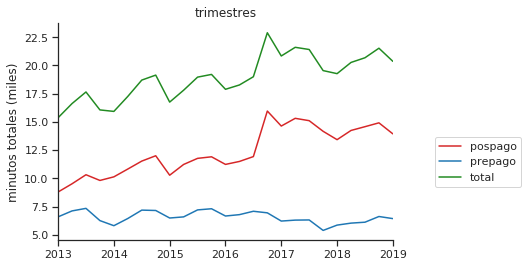

In [177]:
fig, ax= plt.subplots();#figsize=(9,6))
y1.plot(color=red)
y2.plot(color=blue)
y3.plot(color=green)
ax.set_xlabel('')
ax.set_ylabel('minutos totales (miles)')
ax.set_title('trimestres')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot


plt.legend(['pospago','prepago', 'total'],loc='best', bbox_to_anchor=(0.9, 0., 0.5, 0.5))
sns.despine()
plt.show()

Se puede ver que las series 'pospago' y 'total' tienen un comportamiento muy similar mientras que 'prepago' se mantiene aproximadamente constante, por lo que el mayor aporte a los minutos salientes totales serán de las líneas pospagos.

In [124]:
data.describe().round(2)

,Trimestre,Pospago,Prepago,Total
count,25.00,25.00,25.00,25.00
mean,2.44,12.36,6.56,18.92
std,1.16,2.09,0.52,1.98
min,1.00,8.79,5.38,15.37
25%,1.00,10.82,6.25,17.65
50%,2.00,11.91,6.58,19.00
75%,3.00,14.24,7.08,20.36
max,4.00,15.96,7.34,22.90


Vemos que tenemos 25 trimestres para cada series. Vemos que la suma de las medias de los minutos de los prepagos y postpagos se corresponden con la media de la total de minutos salientes, siendo el mayor aporte de las líneas pospago.

In [132]:
data['2016Q1':'2016Q4']

,Trimestre,Pospago,Prepago,Total,Período
2016Q1,1,11.230991,6.656647,17.887638,Ene-Mar 2016
2016Q2,2,11.493027,6.778732,18.271759,Abr-Jun 2016
2016Q3,3,11.923391,7.077838,19.001229,Jul-Sept 2016
2016Q4,4,15.960765,6.938892,22.899656,Oct-Dic 2016


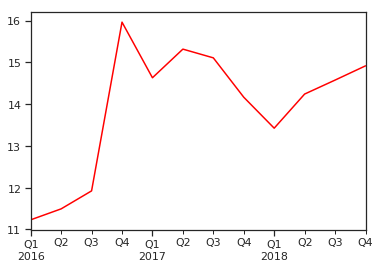

In [178]:
data['2016':'2018']['Pospago'].plot(color='red',figsize=(6,4));
#data['2016']['Prepago'].plot(color='blue',figsize=(6,4));
#data['2016']['Total'].plot(color='green',figsize=(6,4));


Para comparar por períodos:

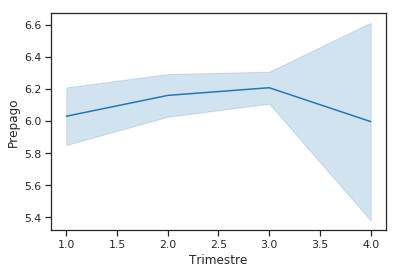

In [209]:
sns.lineplot('Trimestre','Prepago', data=data['2017':'2018'],markers='None');

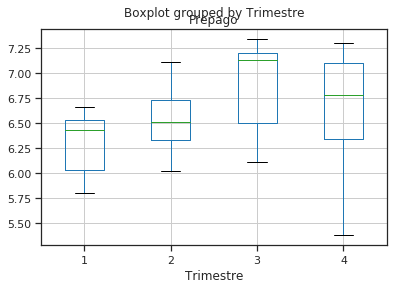

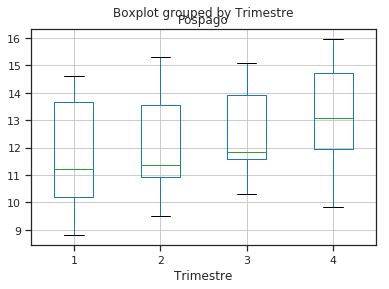

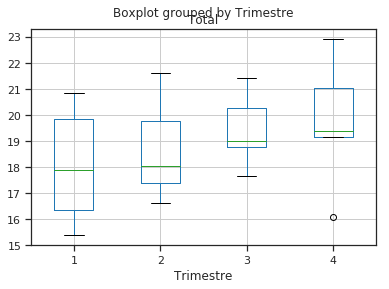

In [217]:
data.boxplot(column='Prepago',by='Trimestre');
data.boxplot(column='Pospago',by='Trimestre');
data.boxplot(column='Total',by='Trimestre');


We can also do a lag graph

In [218]:
from pandas.plotting import lag_plot

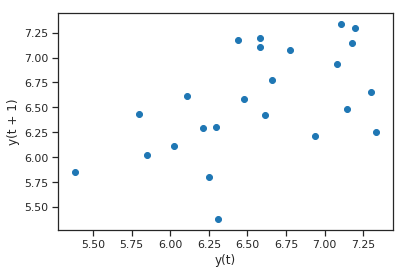

In [219]:
lag_plot(data['Prepago']);

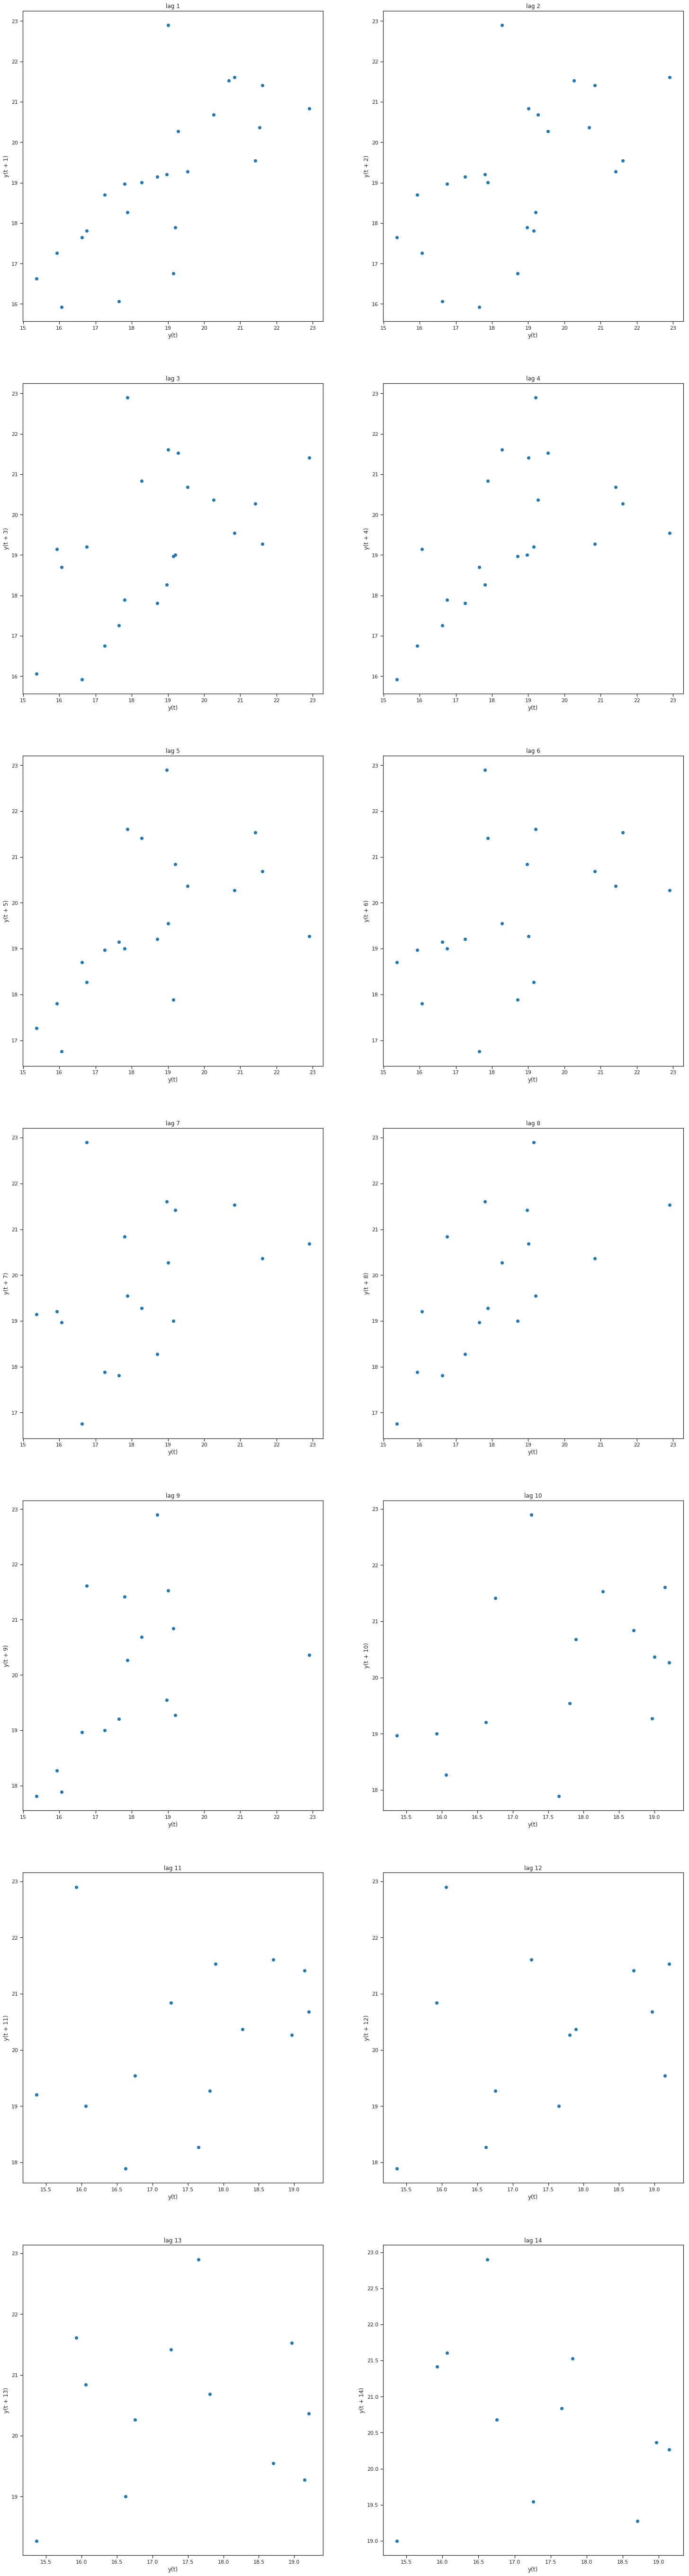

In [230]:
plt.rcParams['figure.figsize'] = [25, 200]
for i in range(14):
   plt.subplot(14,2,i+1)
   plt.title("lag " + str(i+1))
   lag_plot(data['Total'],lag=i+1);

## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [44]:
y=data['Total de minutos salientes (miles)']/10**6

In [45]:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2019Q2    20.364355
2019Q3    20.364355
2019Q4    20.364355
2020Q1    20.364355
Freq: Q-DEC, dtype: float64

To compute interval forecasts, we first estimate the standard deviation of the errors.

In [46]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1.41

Using the formulas from the lecture, the interval forecasts are as below. 

In [47]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2019Q2,17.602,23.127
2019Q3,16.457,24.271
2019Q4,15.579,25.150
2020Q1,14.839,25.890


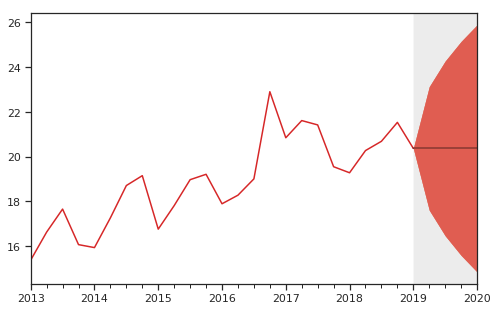

In [48]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y['2010':],point_pred,intv,intv,intv)

plt.show()

## Simple exponential smoothing

The exponential smoothing functions are available since version 0.9 of statsmodels in the **tsa.
holtwinters** module. Take a look in the official [docs](https://www.statsmodels.org/stable/tsa.html#exponential-smoothing). Also, they are improving them, so follow the news for the next release.

In [49]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
model_ses.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,43.434
Optimized:,True,AIC,17.809
Trend:,None,BIC,20.247
Seasonal:,None,AICC,19.809
Seasonal Periods:,None,Date:,"Tue, 17 Sep 2019"
Box-Cox:,False,Time:,10:12:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5438125,alpha,True
initial_level,16.035260,l.0,True


Also AIC and BIC looks off so we are continue our analysis with MSE.

In [50]:
mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))

 In-sample fit:
 MSE               1.737


You can calculate AIC and BIC as follows

In [51]:
N = len(y)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -42.378
 AIC               90.756
 BIC               94.413


Now, let's see how the smoothed data fits the original data

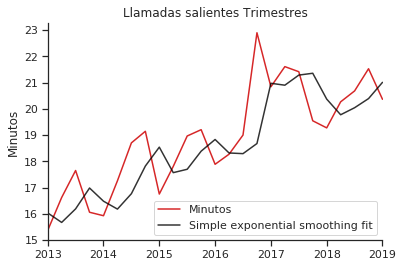

In [52]:
fig, ax= plt.subplots();#figsize=(9,6))
y.plot(color=red, label='Minutos')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos')
ax.set_title('Llamadas salientes Trimestres')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

We compute the residuals as follows.

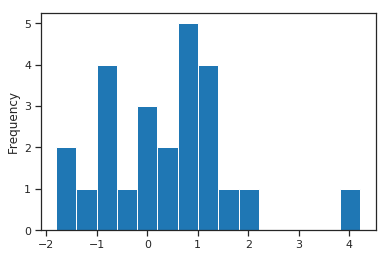

In [53]:
resid=y-fitted_ses
resid.plot.hist(bins=15)# model_ses.resid isn't a panda.Series, so no index, no plot

The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the 80s), and are non-Gaussian. 

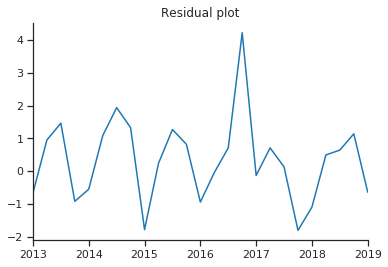

In [54]:
fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

Next is the residual ACF plot aka correlogram

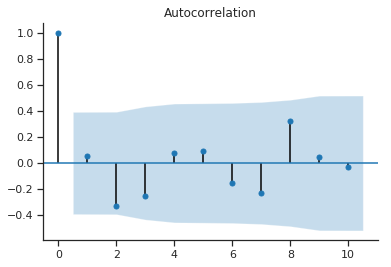

In [55]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax)
sns.despine()
plt.show()

Plotting histogram (in blue) and kernel density estimation (in black) for the residuals

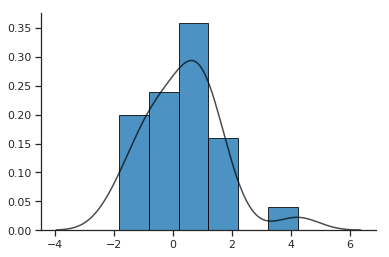

In [56]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

## Model validation

We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

In [57]:
# Real time forecasting - use it as a template - expanding window

validation=y['2017Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2017Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

,RW,SES,Actual
2018Q1,19.545262,20.379837,19.274565
2018Q2,19.274565,19.677908,20.267591
2018Q3,20.267591,20.038137,20.682782
2018Q4,20.682782,20.396708,21.528745
2019Q1,21.528745,21.062302,20.364355


We find that simple exponential smoothing generates more accurate forecasts. 

In [58]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,1.139,0.390
SES,1.150,0.394


## Forecast

We show how to do expanding and rolling point forecast. 

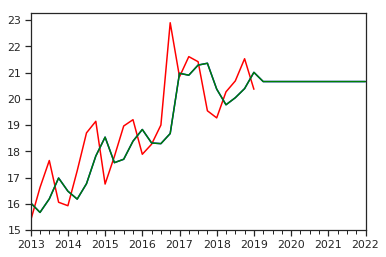

In [59]:
h=12
w=h*10
data = y
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');

In this case, **statsmodels** doesn't provide interval forecast